# FILM RECOMMENDATION SYSTEM

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import joblib
from joblib import dump, load
import time

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing data

# titles data
netflix_titles = pd.read_csv('../data/Netflix/titles.csv')
netflix_titles = netflix_titles[netflix_titles['type']=='MOVIE']

amazon_titles = pd.read_csv('../data/Amazon_prime/titles.csv')
amazon_titles = amazon_titles[amazon_titles['type']=='MOVIE']

# credits data
netflix_credits = pd.read_csv('../data/Netflix/credits.csv')
netflix_credits = netflix_credits.loc[:, ('id', 'name')][netflix_credits['role']=='ACTOR']
netflix_credits = netflix_credits.groupby('id')['name'].apply(', '.join).reset_index()

amazon_credits = pd.read_csv('../data/Amazon_prime/credits.csv')
amazon_credits = amazon_credits.loc[:, ('id', 'name')][amazon_credits['role']=='ACTOR']
amazon_credits = amazon_credits.groupby('id')['name'].apply(', '.join).reset_index()

In [3]:
# Merging data for each plateform
netflix = netflix_titles.merge(netflix_credits, on='id', how='left')
amazon = amazon_titles.merge(amazon_credits, on='id', how='left')

In [4]:
# Concatenating data
dataset = pd.concat([netflix, amazon], axis=0).reset_index()

In [5]:
dataset.shape

(13153, 17)

In [6]:
dataset.head(2)

,index,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,name
0,0,tm82169,Rocky,MOVIE,"When world heavyweight boxing champion, Apollo...",1976,PG,119,"['drama', 'sport']",['US'],NaN,tt0075148,8.1,588100.0,106.361,7.782,"Sylvester Stallone, Talia Shire, Burt Young, C..."
1,1,tm17823,Grease,MOVIE,Australian good girl Sandy and greaser Danny f...,1978,PG,110,"['romance', 'comedy']",['US'],NaN,tt0077631,7.2,283316.0,33.160,7.406,"John Travolta, Olivia Newton-John, Stockard Ch..."


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13153 entries, 0 to 13152
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 13153 non-null  int64  
 1   id                    13153 non-null  object 
 2   title                 13153 non-null  object 
 3   type                  13153 non-null  object 
 4   description           13032 non-null  object 
 5   release_year          13153 non-null  int64  
 6   age_certification     4209 non-null   object 
 7   runtime               13153 non-null  int64  
 8   genres                13153 non-null  object 
 9   production_countries  13153 non-null  object 
 10  seasons               0 non-null      float64
 11  imdb_id               12315 non-null  object 
 12  imdb_score            11941 non-null  float64
 13  imdb_votes            11916 non-null  float64
 14  tmdb_popularity       12670 non-null  float64
 15  tmdb_score         

In [8]:
dataset.describe()

,index,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
count,19455.000000,19455.000000,19455.000000,0.0,17372.000000,1.731500e+04,18926.000000,17050.000000
mean,2966.487227,2003.043793,92.343922,NaN,6.059671,2.717334e+04,10.770341,6.108614
std,2567.459707,25.638392,30.800705,NaN,1.244623,1.123930e+05,43.942464,1.332341
min,0.000000,1901.000000,1.000000,NaN,1.100000,5.000000e+00,0.000153,0.500000
25%,960.000000,1999.000000,78.000000,NaN,5.300000,2.020000e+02,1.671000,5.400000
50%,2087.000000,2015.000000,92.000000,NaN,6.200000,1.044000e+03,3.713000,6.200000
75%,4457.500000,2019.000000,107.000000,NaN,7.000000,7.266500e+03,9.773750,7.000000
max,9321.000000,2023.000000,940.000000,NaN,9.900000,2.684317e+06,3187.531000,10.000000


In [8]:
dataset.isnull().sum()/dataset.shape[0]

index                   0.000000
id                      0.000000
title                   0.000000
type                    0.000000
description             0.009199
release_year            0.000000
age_certification       0.679997
runtime                 0.000000
genres                  0.000000
production_countries    0.000000
seasons                 1.000000
imdb_id                 0.063712
imdb_score              0.092146
imdb_votes              0.094047
tmdb_popularity         0.036722
tmdb_score              0.147191
name                    0.086216
dtype: float64

<Figure size 800x500 with 0 Axes>

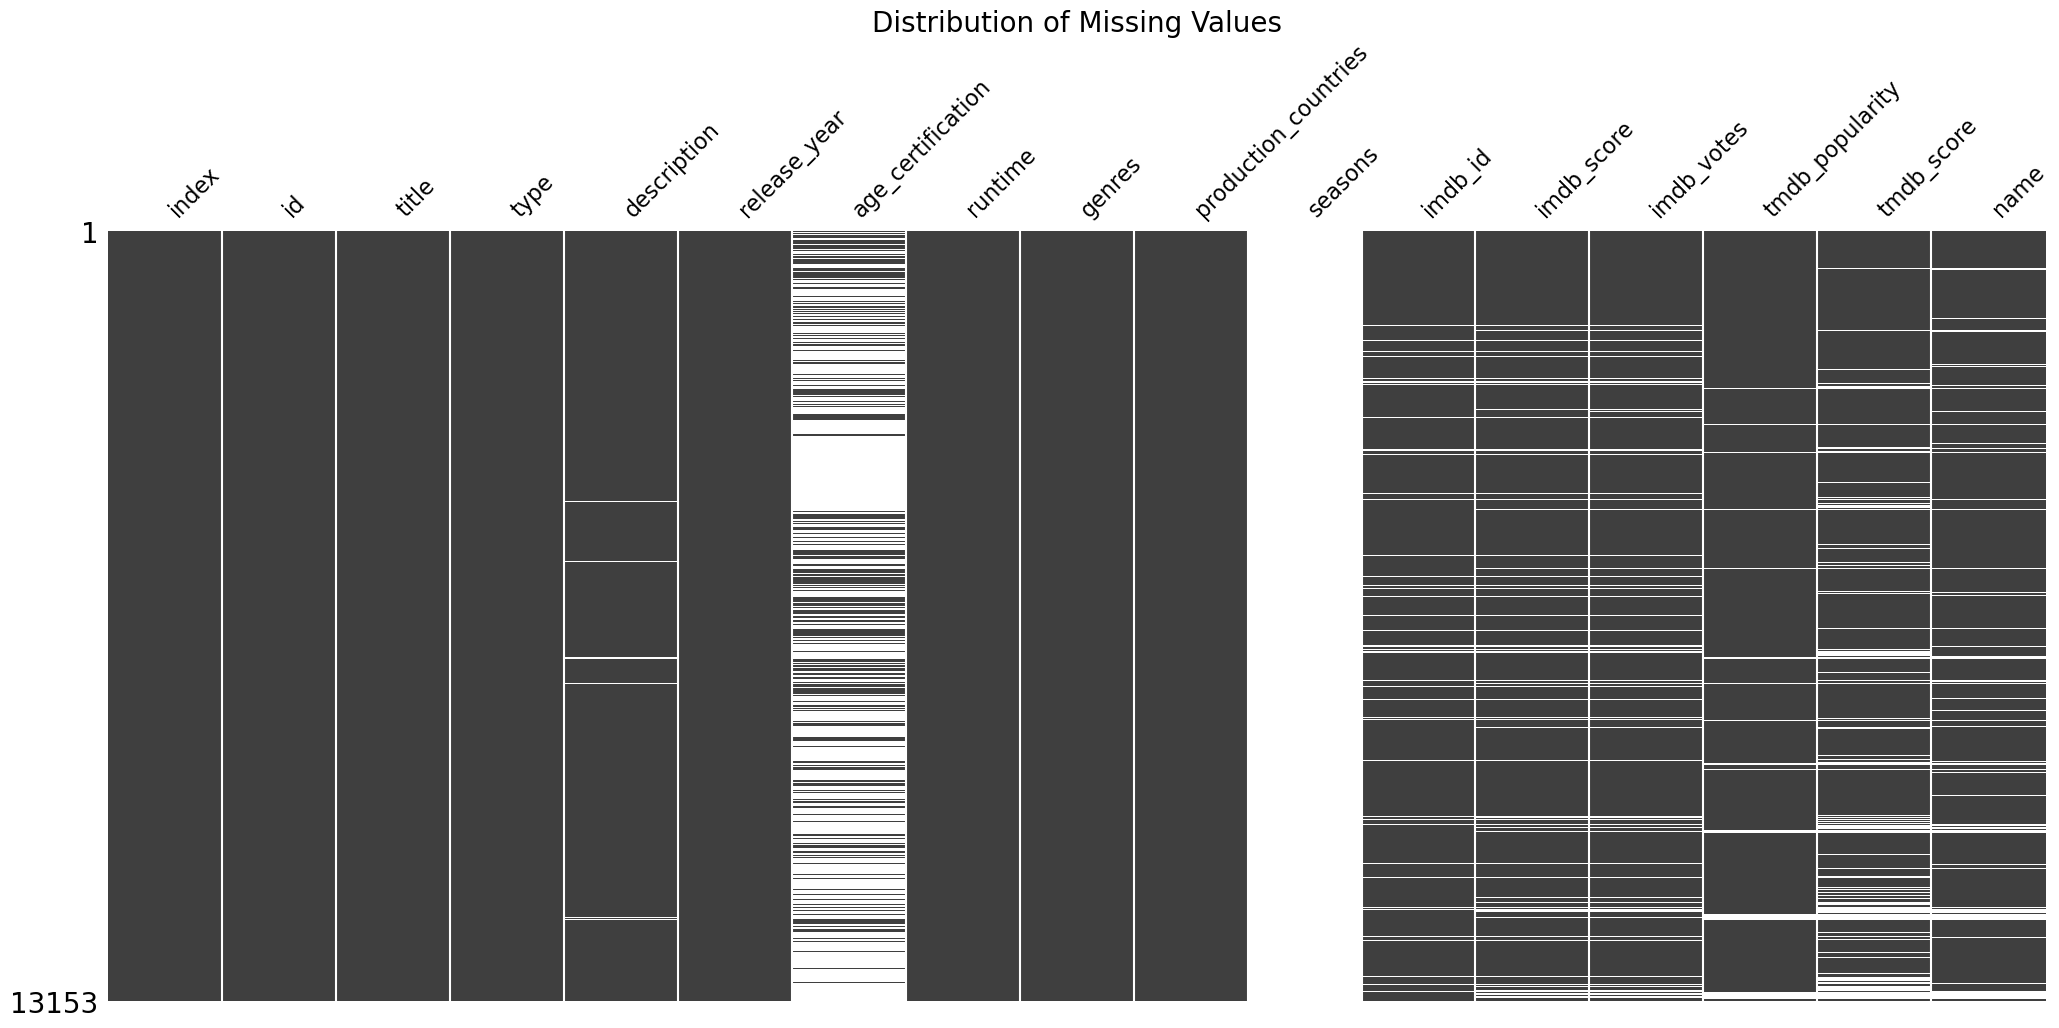

In [9]:
plt.figure(figsize=(8,5))
msno.matrix(dataset, sparkline=False)
plt.title('Distribution of Missing Values', size=20)
plt.show()

In [10]:
# Checking data duplicates
dataset.duplicated().sum()

0

In [11]:
# Checking id duplicates
dataset['id'].duplicated().sum()

87

In [12]:
# Checking title duplicates
dataset['title'].duplicated().sum()

278

## PREPROCESSING DATA

In [13]:
# Dropping 'index', 'type', 'seasons' and 'imdb_id' columns
dataset.drop(['index', 'type', 'seasons', 'imdb_id'], axis=1, inplace=True)

In [14]:
# Removing duplicates
dataset = dataset.drop_duplicates(subset=['title'], keep='first').reset_index()

### release_year

In [15]:
# film release year range from 1901 to 2023
dataset['release_year'].describe()

count    12875.000000
mean      2006.637670
std         23.435384
min       1912.000000
25%       2007.000000
50%       2017.000000
75%       2020.000000
max       2023.000000
Name: release_year, dtype: float64

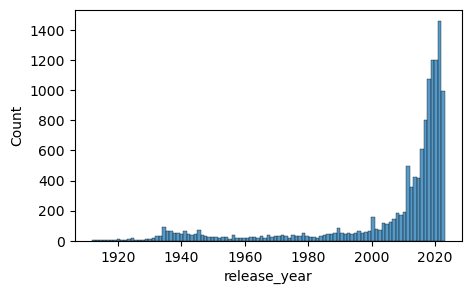

In [16]:
# Inspecting release year distribution
plt.figure(figsize=(5,3))
sns.histplot(dataset['release_year'])
plt.show()

In [17]:
# Regrouping film release year into 2 groups
dataset['release_year'] = dataset['release_year'].apply(lambda x: 0 if x<2015 else 1)

In [18]:
# Converting release year into dummy variables
dataset = pd.get_dummies(dataset, columns=['release_year'], prefix='year', drop_first=True)

### age_certification

In [19]:
dataset['age_certification'].value_counts()
# an R rating means that no one under 17 can see this movie unless the parent is with them
# PG-13 means that this movie may not be suitable for kids under 13
# PG means parental guidance. The movie is likely for children, but parents should watch the movie with their children
# A movie that is meant for children will likely be rated as G
# NC-17 as an “adults alone” rating that signifies that no one under the age of 17 can see the film

R        1795
PG-13    1090
PG        817
G         370
NC-17      25
Name: age_certification, dtype: int64

In [20]:
# Replacing null values by NR (not rated)
dataset['age_certification'].fillna('NR', inplace=True)

In [21]:
# Encoding age certification
dataset = pd.get_dummies(dataset, columns=['age_certification'], prefix='age', drop_first=True)

### runtime

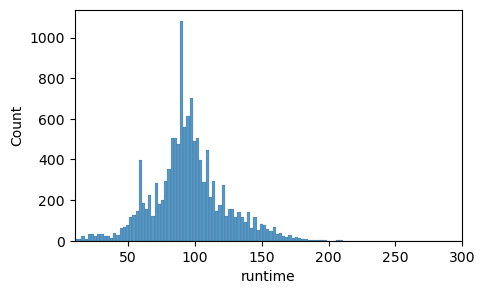

In [22]:
plt.figure(figsize=(5,3))
sns.histplot(dataset['runtime'])
plt.xlim(10, 300)
plt.show()

In [23]:
# How much film shorter than 30 minutes?
len(dataset[dataset['runtime']<30])

191

In [24]:
# Regulate short film duration to 30 minutes for avoiding outliers
dataset['runtime'] = dataset['runtime'].apply(lambda x: 30 if x<30 else x)

### genre

In [25]:
# Cleaning text
dataset['genres'] = dataset['genres'].str.replace('[', '')
dataset['genres'] = dataset['genres'].str.replace(']', '')
dataset['genres'] = dataset['genres'].str.replace("'", "")
dataset['genres'] = dataset['genres'].str.replace(' ', '')

In [26]:
# Getting genres list for each film
dataset['genres']=dataset['genres'].str.split(',')

In [27]:
# Retrieving genres list of all films
genres_list = [j for i in dataset['genres'] for j in i]
genres_set = set(genres_list)
genres_set.discard('')

In [28]:
# Checking number of all genres
len(genres_set)

19

In [29]:
# Creating new columns corresponding to each genre

## Building function to get dummies genres
def get_dummies_genres(data):
    unique_genres = list(genres_set)
    unique_genres.sort()
    dummy_matrix = []
    for d in data:
        row = [int(genre in d) for genre in unique_genres]
        dummy_matrix.append(row)
    dummies = {}
    for i, col_name in enumerate(unique_genres):
        col_values = [row[i] for row in dummy_matrix]
        dummies[col_name] = col_values
    return dummies

## Getting the genre dummies data
dummies_genres = get_dummies_genres(dataset['genres'])

## Adding new genre columns to dataset
for key in dummies_genres.keys():
    col = 'genre_'+str(key)
    dataset[col] = dummies_genres[key]

## Removing original genres column
dataset.drop(['genres'], axis=1, inplace=True)

### production_countries

In [30]:
# Checking number of films with no production country recorded
len(dataset[dataset['production_countries']=='[]'])

703

In [31]:
# Replacing missing records by most frequent value (US)
dataset['production_countries'].replace(to_replace="[]", value="['US']", inplace=True)

In [32]:
# Cleaning text
dataset['production_countries'] = dataset['production_countries'].str.replace('[', '')
dataset['production_countries'] = dataset['production_countries'].str.replace(']', '')
dataset['production_countries'] = dataset['production_countries'].str.replace("'", "")

In [33]:
# Getting countries list for each film
dataset['production_countries']=dataset['production_countries'].str.split(', ')

In [34]:
# Retrieving countries list of all films
countries_list = [j for i in dataset['production_countries'] for j in i]
countries_set = set(countries_list)

In [35]:
# Checking number of all countries
len(countries_set)

145

In [36]:
# Creating new columns corresponding to each country

## Building function to get dummies countries
def get_dummies_countries(data):
    unique_countries = list(countries_set)
    unique_countries.sort()
    dummy_matrix = []
    for d in data:
        row = [int(country in d) for country in unique_countries]
        dummy_matrix.append(row)
    dummies = {}
    for i, col_name in enumerate(unique_countries):
        col_values = [row[i] for row in dummy_matrix]
        dummies[col_name] = col_values
    return dummies

## Getting the genre dummies data
dummies_countries = get_dummies_countries(dataset['production_countries'])

## Adding new genre columns to dataset
for key in dummies_countries.keys():
    col = 'country_'+str(key)
    dataset[col] = dummies_countries[key]

## Removing original genres column
dataset.drop(['production_countries'], axis=1, inplace=True)

### name

In [37]:
# Replacing missing values
dataset['name'].fillna('NoName', inplace=True)

In [38]:
# Getting actors list for each film
dataset['name']=dataset['name'].str.split(', ')

In [39]:
# Retrieving actors list of all films
actors_list = [j for i in dataset['name'] for j in i]
actors_set = set(actors_list)

In [40]:
# Checking number of all actors
len(actors_set)

111043

In [41]:
# The actors list is to large, we decide to limit this list into 200 (100 Greatest Actors and 100 Greatest Actresses 
# of All Time following IMDB selection
# (reference links: https://www.imdb.com/list/ls050274118/ ; https://www.imdb.com/list/ls000055475/)
greatest_actors = ['Jack Nicholson', 'Marlon Brando', 'Robert De Niro', 'Al Pacino', 'Daniel Day-Lewis', 'Dustin Hoffman', 'Tom Hanks', 
             'Anthony Hopkins', 'Paul Newman', 'Denzel Washington', 'Spencer Tracy', 'Laurence Olivier', 'Jack Lemmon', 
             'Michael Caine', 'James Stewart', 'Robin Williams', 'Robert Duvall', 'Sean Penn', 'Morgan Freeman', 'Jeff Bridges', 
             'Sidney Poitier', 'Peter OToole', 'Clint Eastwood', 'Gene Hackman', 'Charles Chaplin', 'Ben Kingsley', 
              'Philip Seymour Hoffman', 'Leonardo DiCaprio', 'Russell Crowe', 'Kevin Spacey', 'Humphrey Bogart', 'Gregory Peck', 
             'Clark Gable', 'Gary Cooper', 'George C. Scott', 'Jason Robards', 'Charles Laughton', 'Anthony Quinn', 'Peter Sellers', 
             'James Cagney', 'Peter Finch', 'Henry Fonda', 'Cary Grant', 'Richard Burton', 'Burt Lancaster', 'William Holden', 
             'John Wayne', 'Kirk Douglas', 'Alec Guinness', 'Christopher Plummer', 'Tommy Lee Jones', 'Sean Connery', 'Alan Arkin', 
             'Christopher Walken', 'Joe Pesci', 'Ian McKellen', 'Michael Douglas', 'Jon Voight', 'Albert Finney', 'Geoffrey Rush', 
             'Jeremy Irons', 'Javier Bardem', 'Heath Ledger', 'Christoph Waltz', 'Ralph Fiennes', 'Johnny Depp', 'Benicio Del Toro', 
             'Jamie Foxx', 'Joaquin Phoenix', 'Colin Firth', 'Matthew McConaughey', 'Christian Bale', 'Gary Oldman', 'Edward Norton', 
             'Brad Pitt', 'Tom Cruise', 'Matt Damon', 'Hugh Jackman', 'Robert Downey Jr.', 'Liam Neeson', 'Mel Gibson', 'Harrison Ford',
             'Woody Allen', 'Steve McQueen', 'Orson Welles', 'Robert Redford', 'James Dean', 'Charlton Heston', 'Gene Kelly', 
             'Robert Mitchum', 'Bill Murray', 'Samuel L. Jackson', 'Jim Carrey', 'Don Cheadle', 'Martin Sheen', 'Alan Rickman', 
             'Edward G. Robinson', 'Will Smith', 'John Goodman', 'Buster Keaton', 'Meryl Streep', 'Ingrid Bergman', 'Vivien Leigh', 
             'Bette Davis', 'Jodie Foster', 'Katharine Hepburn', 'Elizabeth Taylor', 'Kate Winslet', 'Hilary Swank', 'Naomi Watts', 
             'Shirley MacLaine', 'Natalie Portman', 'Jennifer Connelly', 'Susan Sarandon', 'Charlize Theron', 'Cate Blanchett', 
             'Rachel Weisz', 'Diane Lane', 'Sharon Stone', 'Scarlett Johansson', 'Juliette Lewis', 'Gwyneth Paltrow', 'Helen Mirren', 
             'Judi Dench', 'Monica Bellucci', 'Angelina Jolie', 'Nicole Kidman', 'Anjelica Huston', 'Romy Schneider', 'Ashley Judd', 
             'Grace Kelly', 'Patricia Clarkson', 'Simone Signoret', 'Isabelle Adjani', 'Marion Cotillard', 'Sigourney Weaver', 
             'Jane Fonda', 'Helen Hunt', 'Frances McDormand', 'Jessica Lange', 'Catherine Deneuve', 'Barbara Stanwyck', 'Holly Hunter', 
             'Kathy Bates', 'Sissy Spacek', 'Sally Field', 'Diane Keaton', 'Faye Dunaway', 'Penélope Cruz', 'Laura Dern', 'Sophia Loren', 
             'Ellen Burstyn', 'Julie Christie', 'Olivia de Havilland', 'Greer Garson', 'Helena Bonham Carter', 'Geena Davis', 
             'Audrey Tautou', 'Rachel McAdams', 'Tilda Swinton', 'Elisabeth Shue', 'Maggie Gyllenhaal', 'Maria Bello', 'Franka Potente', 
             'Kristin Scott Thomas', 'Barbra Streisand', 'Juliette Binoche', 'Kathleen Turner', 'Lauren Bacall', 'Ellen Barkin', 
             'Shelley Winters', 'Vanessa Redgrave', 'Audrey Hepburn', 'Greta Garbo', 'Glenn Close', 'Catherine Zeta-Jones', 
             'Emmanuelle Béart', 'Marisa Tomei', 'Geraldine Chaplin', 'Jennifer Jason Leigh', 'Birgit Minichmayr', 'Deborah Kerr', 
             'Julianne Moore', 'Emmanuelle Seigner', 'Isabelle Huppert', 'Brittany Murphy', 'Uma Thurman', 'Michelle Pfeiffer', 
             'Evan Rachel Wood', 'Toni Collette', 'Whoopi Goldberg', 'Charlotte Rampling', 'Demi Moore', 'Sibel Kekilli', 'Rita Hayworth', 
             'Amanda Seyfried', 'Sophie Marceau', 'Victoria Abril', 'Giulietta Masina', 'Doris Day']

In [42]:
# Creating new columns corresponding to each actor

## Building function to get dummies actors
def get_dummies_actors(data):
    greatest_actors.sort()
    dummy_matrix = []
    for d in data:
        row = [int(actor in d) for actor in greatest_actors]
        dummy_matrix.append(row)
    dummies = {}
    for i, col_name in enumerate(greatest_actors):
        col_values = [row[i] for row in dummy_matrix]
        dummies[col_name] = col_values
    return dummies

## Getting the actors dummies matrix
dummies_actors = get_dummies_actors(dataset['name'])

## Adding new columns corresponding to actor in the list
for actor in dummies_actors.keys():
    col = 'actor_'+str(actor)
    dataset[col] = dummies_actors[actor]

## Removing original genres column
dataset.drop(['name'], axis=1, inplace=True)

### imdb_score, imdb_votes, tmdb_popularity, tmdb_score

In [43]:
# processing missing values

## imdb_votes, tmdb_popularity: replace missing values using column's mean
dataset['imdb_votes'].fillna(int(dataset['imdb_votes'].mean()), inplace=True)
dataset['tmdb_popularity'].fillna(dataset['tmdb_popularity'].mean(), inplace=True)

# imdb_score, tmdb_score: fill missing values using KNN Imputation
imputer = KNNImputer(n_neighbors=10, weights='distance', metric='nan_euclidean')

dataset['imdb_score'] = imputer.fit_transform(np.array(dataset['imdb_score']).reshape(-1, 1))
dataset['imdb_score'] = dataset['imdb_score'].apply(lambda x: round(x, 1))

dataset['tmdb_score'] = imputer.fit_transform(np.array(dataset['tmdb_score']).reshape(-1, 1))
dataset['tmdb_score'] = dataset['tmdb_score'].apply(lambda x: round(x, 1))

### Rescaling data

In [44]:
scaler = MinMaxScaler()
dataset['runtime'] = scaler.fit_transform(np.array(dataset['runtime']).reshape(-1, 1))
dataset['imdb_score'] = scaler.fit_transform(np.array(dataset['imdb_score']).reshape(-1, 1))
dataset['imdb_votes'] = scaler.fit_transform(np.array(dataset['imdb_votes']).reshape(-1, 1))
dataset['tmdb_score'] = scaler.fit_transform(np.array(dataset['tmdb_score']).reshape(-1, 1))
dataset['tmdb_popularity'] = scaler.fit_transform(np.array(dataset['tmdb_popularity']).reshape(-1, 1))

### description

In [45]:
# Removing cell with description missing values
dataset.dropna(axis=0, inplace=True)

## MODELLING

In [47]:
# We will caculate movies similarities based on 1.movies characteristic features and 2.movies description 

In [46]:
# Retrieving data for models building
data_text = dataset.loc[:, ('title', 'description')]
data_characteristics = dataset.drop(['index', 'id', 'description'], axis=1)

### Calculating movies similarity basing on movies characteristics

In [47]:
# Creating movies dictionnary
movies_dict = data_characteristics.set_index('title').T.to_dict('list')
# Building movies characteristics matrix
movie_matrix = np.array(list(movies_dict.values()))
# Building movies similarity matrix
similarity_matrix_char = cosine_similarity(movie_matrix)

### Calculating movies similarity basing on movies description

In [ ]:
# Here we will implement AutoEncoders model to capture text similarity

In [48]:
# Set model parameters
max_words = 1000
latent_dim = 100
#sequence_length = 10
batch_size = 6
epochs = 20

In [49]:
# Create tokenizer for converting text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(data_text['description']))
sequences = tokenizer.texts_to_sequences(list(data_text['description']))

In [50]:
# Convert text sequences into one-hot vectors
input_data = tokenizer.sequences_to_matrix(sequences, mode='binary') # use binary mode since data values are all 0 or 1

In [51]:
# Create model architecture
input_dim = input_data.shape[1]

# Encoder
inputs = Input(shape=(input_dim,))
encoded = Dense(256, activation='relu')(inputs)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(latent_dim, activation='relu')(encoded)

# Define Encoder model
encoder = Model(inputs, encoded)

# Decoder
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Define AutoEncoder model
autoencoder = Model(inputs, decoded)

In [52]:
# Get model summary
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 256)               256256    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 100)               12900     
                                                                 
 dense_3 (Dense)             (None, 128)               12928     
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dense_5 (Dense)             (None, 1000)              2570

In [53]:
# Train model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(input_data, input_data, epochs=epochs, batch_size=batch_size)

Epoch 1/20
2126/2126 [==============================] - 26s 10ms/step - loss: 0.0849
Epoch 2/20
2126/2126 [==============================] - 19s 9ms/step - loss: 0.0690
Epoch 3/20
2126/2126 [==============================] - 18s 8ms/step - loss: 0.0627
Epoch 4/20
2126/2126 [==============================] - 18s 9ms/step - loss: 0.0590
Epoch 5/20
2126/2126 [==============================] - 18s 9ms/step - loss: 0.0563
Epoch 6/20
2126/2126 [==============================] - 18s 8ms/step - loss: 0.0542
Epoch 7/20
2126/2126 [==============================] - 18s 8ms/step - loss: 0.0523
Epoch 8/20
2126/2126 [==============================] - 18s 8ms/step - loss: 0.0507
Epoch 9/20
2126/2126 [==============================] - 18s 9ms/step - loss: 0.0494
Epoch 10/20
2126/2126 [==============================] - 18s 8ms/step - loss: 0.0481
Epoch 11/20
2126/2126 [==============================] - 18s 8ms/step - loss: 0.0471
Epoch 12/20
2126/2126 [==============================] - 18s 8ms/step - l

In [54]:
# Recuperate encoded version of input data
encoded_texts = encoder.predict(input_data) 

399/399 [==============================] - 3s 7ms/step


In [55]:
# Recuperate similarity matrix
similarity_matrix_ae = cosine_similarity(encoded_texts)

### Generate final similarity matrix

In [56]:
# Generate similarity matrix
similarity_matrix = (np.array(similarity_matrix_char) + np.array(similarity_matrix_ae))/2
# Create similarity dataframe
movies_list = [movie for movie in dataset['title']]
similarity_frame = pd.DataFrame(data=similarity_matrix, index=movies_list, columns=movies_list)

In [57]:
pickle_file = 'pickle_frame.joblib'
start = time.time()
with open(pickle_file, 'wb') as f:
    dump(similarity_frame, f)
raw_dump_duration = time.time() - start
print("Raw dump duration: %0.3fs" % raw_dump_duration)

Raw dump duration: 3.323s
